# Average grain size distribution 

- I am using the dataframe created in the previous file to calculate the average HH corr
- Since I have different scansizes and pixel numbers (and therefore, different stepsize), I take the smallest stepsize and I create the interpolated HH corr function over this new scale.
- Once I have the interpolated functions, I can easily average them.

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
import pickle
import math

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


from matplotlib import cm
from skimage import data, img_as_float

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.stats import sem

In [29]:
debug = True 

path = "/Users/sfiligoj/Desktop/Thesis/Data Analysis/SEM/SEM_all"
os.chdir(path)
# Load the dictionary back from the pickle file.
df = pickle.load( open( "save_with2newFiles.p", "rb" ) )

if debug: print(f'select specific density')
if debug: df = df[df.density=='L']
df

select specific density


,filename,density,temp,hhcorr,scansize,n_pix
7,L_asdep_006.tif,L,25,"[18686906.280749314, 21295198.403640527, 23459...",518,1024
10,L_700C_300nm_058.tif,L,700,"[41837748.74194574, 47564039.11361674, 5241911...",414,1024
15,L_700C_1um_055.tif,L,700,"[36030172.69093419, 42521504.90594379, 4923548...",518,1024
17,L_asdep_004.tif,L,25,"[18433189.8862925, 20704404.916669425, 2238956...",345,1024
22,L_asdep_005.tif,L,25,"[18459128.6384772, 20596702.705750387, 2207164...",345,1024
23,L_700C_1um_054.tif,L,700,"[46985991.784339376, 74817980.24956329, 109609...",1180,1024
24,L_700C_2um_048.tif,L,700,"[58414613.95741424, 106108186.5710255, 1582939...",1660,1024
29,L_700C_1um_050.tif,L,700,"[48092479.438367136, 82715239.42744854, 125674...",1180,1024
30,L_asdep_001.tif,L,25,"[18984276.393238496, 21372573.70167289, 231380...",345,1024
34,L_800C_XPS_003.tif,L,800,"[30023777.74594997, 33291631.537327733, 353968...",345,1024


# Data exclusion:

In [3]:
df.drop(df[df.scansize==276].index, inplace=True)
df.drop(df[df.scansize==345].index, inplace=True)
df.drop(df[df.scansize==414].index, inplace=True)
# df.drop(df[df.scansize==518].index, inplace=True)

# df.drop(df[df.scansize==638].index, inplace=True)
# df.drop(df[df.scansize==829].index, inplace=True)
# df.drop(df[df.scansize==1180].index, inplace=True)

df.drop(df[df.scansize==1660].index, inplace=True)
df.drop(df[df.scansize==2070].index, inplace=True)
df.drop(df[df.scansize==2760].index, inplace=True)

df.drop(df[df.scansize==3450].index, inplace=True)
df.drop(df[df.scansize==4140].index, inplace=True)
df.drop(df[df.scansize==4830].index, inplace=True)

df.drop(df[df.scansize==5180].index, inplace=True)
df.drop(df[df.scansize==6380].index, inplace=True)
df.drop(df[df.scansize==8290].index, inplace=True)


df.drop(df[df.scansize==11800].index, inplace=True)
df.drop(df[df.scansize==16600].index, inplace=True)
df.drop(df[df.scansize==20700].index, inplace=True)
df.drop(df[df.scansize==82900].index, inplace=True)

In [4]:
#Low density:
df.drop(index=50, inplace= True) #: file111 High density AsDep
df.drop(index=5, inplace= True) #: file111 Low-High density AsDep


df.drop(index=75, inplace= True) #: file060 Low density 700C
df.drop(index=91, inplace= True) #: file052 Low density 700C

# Low-High density:
df.drop(index=98, inplace= True) #: file006 Low-High density 250C

df.drop(index=44, inplace= True) #: file073 Low-High density 700C
df.drop(index=117, inplace= True) #: file082 Low-High density 700C
df.drop(index=8, inplace= True) #: file076 Low-High density 700C

df.drop(index=18, inplace= True) #: file029 Low-High density 800C

## For file save.p:

# #Low density:
# df.drop(index=77, inplace= True) #: file060 Low density 700C
# df.drop(index=93, inplace= True) #: file052 Low density 700C

# # Low-High density:
# df.drop(index=100, inplace= True) #: file006 Low-High density 250C

# df.drop(index=46, inplace= True) #: file073 Low-High density 700C
# df.drop(index=121, inplace= True) #: file082 Low-High density 700C
# df.drop(index=8, inplace= True) #: file076 Low-High density 700C

# df.drop(index=18, inplace= True) #: file029 Low-High density 800C

# Calculation of interpolated HHcorr's:
- Since x_new was different for L, LH and H I had to crate a loop through the densities.

In [5]:
densities = ['L','H','LH']
df['hhcorr_interp'] = 'default value'
df['px_size'] = df.scansize / df.n_pix

x_new={}
for d in densities:
    sel = df[df.density==d]
    # we create Xdelta for each row, all at once
    x_delta = [np.arange(px_size, scan_size+px_size, px_size) for px_size, scan_size in zip(sel.px_size, sel.scansize)] 
    # we take the minimun px_size, and interpolate all HHcorr at x values whose delta is that minimum
    min_dx = min(sel.px_size)
    min_scansize = min(sel.scansize)
    if False: print(min_dx, min_scansize)
    x_new[d] = np.arange(min_dx, min_scansize, min_dx) # x_new is the new range on which I want to interpolate the data   
    #definition of HHcorr-interpolated+addition to data-frame:
    df['hhcorr_interp'].loc[sel.index] = [np.interp(x_new[d], x, y) for x,y in zip(x_delta, sel.hhcorr)]
df.head(3)

,filename,density,temp,hhcorr,scansize,n_pix,hhcorr_interp,px_size
1,Ru_LH_500C_015.tif,LH,500,"[30971148.212057844, 39822527.95124445, 495364...",829,1024,"[30971148.212057844, 33181323.85260263, 387121...",0.80957
3,H_700C_024.tif,H,700,"[30515781.720810007, 33113456.48294899, 340378...",518,1024,"[30515781.720810007, 33113456.48294899, 340378...",0.505859
4,H_700C_1um_047.tif,H,700,"[37770678.785245955, 43465627.65496086, 478992...",1180,1024,"[37770678.785245955, 37770678.785245955, 39575...",1.15234


# Calculation of Average HHcorr
    Blueprint -> Offset [density][temperature][rows]
    - At a given density and at a given T, all the individual HHcorr have a different starting point. 
    - we adjust for that by introducing an offset
    - we calculate the offset by iterating on the rows of all_hhcorr. 
    - Every row corresponds to a different measurement, and has a different offset
    
    Blueprint -> AvHHcorr [density] [temperature]
    - we take the interpolated HHcorr from the "selection" DataFrame
    - we create an array, where each HHcorr from a different measurement is a full row
    - when we average on the columns, we get the average_HHcorr

In [6]:
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()
df['hhcorr_interp_offset'] = ['']*len(df)

AvHHcorr = {} 
for dens in densities:
    AvHHcorr[dens] = {}
    for temp in temperatures:
        AvHHcorr[dens][temp] = {}
        # create the selection
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
    
        all_hhcorr = np.array(selection.hhcorr_interp.tolist()) 
        
        ref_idx = 1 #first point of the curve
        reference = min(all_hhcorr[:,ref_idx])

        for i,row in enumerate(all_hhcorr): # iterating on rows gives us the single hh_corr
            if row[ref_idx] != reference:   # "if the first point of the curve is different than the minimum..."
                offset = row[ref_idx] - reference  # define offset 
                row -= offset                      # apply offset  
            all_hhcorr[i] = row             # store the new all_hhcorr

        df.hhcorr_interp_offset.at[selection.index] = all_hhcorr.tolist()
        
        AvHHcorr[dens][temp]['value'] = all_hhcorr.mean(axis = 0)
        AvHHcorr[dens][temp]['HH_0'] = AvHHcorr[dens][temp]['value'][ref_idx]
        err = np.ravel(sem(all_hhcorr, axis = 0))
        AvHHcorr[dens][temp]['err']   = err
        AvHHcorr[dens][temp]['value_upper'] = AvHHcorr[dens][temp]['value'] + err
        AvHHcorr[dens][temp]['value_lower'] = AvHHcorr[dens][temp]['value'] - err       

# New data frame with HH$_0$ 
HH$_0$ is the value of HHcorr at the first point of the x-axis

In [7]:
# *** Calculate average HHcorr from interpolated values, and the associated standard deviation
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()
df2 = pd.DataFrame(columns= 
                   ['density',
                    'temp', 
                    'avhhcorr',
                    'xdelta',
                    'HH_0'])

row={}
for dens in densities:
    row[dens] = {}
    for temp in temperatures:
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        row[dens][temp] = {}
            #crei la riga:
        row[dens][temp]['density'] = dens
        row[dens][temp]['temperature'] = temp
        row[dens][temp]['avHHcorr'] = AvHHcorr[dens][temp]['value']
        row[dens][temp]['HH_0'] = AvHHcorr[dens][temp]['HH_0'] 

# *** Create new dataframe for the calculation of CorrLen and Alpha on this data:
        df2 = df2.append( 
                {'density': row[dens][temp]['density'],
                 'temp': row[dens][temp]['temperature'],  
                 'avhhcorr': row[dens][temp]['avHHcorr'], 
                 'xdelta': x_new,
                 'HH_0': row[dens][temp]['HH_0']
                },
                ignore_index=True)
pickle.dump(df2, open("SEM_AvHHcorr_interpolated.p", "wb" ) )
df2.head(3)

,density,temp,avhhcorr,xdelta,HH_0
0,LH,25,"[38350057.83005067, 40192329.95303964, 4327821...","{'L': [0.505859375, 1.01171875, 1.517578125, 2...",4.019233e+07
1,LH,250,"[38129624.63900856, 40412513.61305031, 4450599...","{'L': [0.505859375, 1.01171875, 1.517578125, 2...",4.041251e+07
2,LH,500,"[30916374.231201235, 33181323.85260263, 379572...","{'L': [0.505859375, 1.01171875, 1.517578125, 2...",3.318132e+07


# Offset on AvHHcorr at different temperatures
    Blueprint -> Offset [density][temperature] 
        - Given that here the starting point of the HHcorr curve is arbitrary (that is, it does not represent  any physical quantity) we shift each AvHHcorr of a certain offset
        - We decide to set as a reference the AvHHcorr the one with the minimum value at x=0

In [8]:
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()
# densities = ['H']


adj_hhcorr = {}
for d in densities:
    adj_hhcorr[d]={}
    
    slctn = df2[df2.density==d] 
    ref = min(slctn.HH_0)
       
    for t in temperatures:
        adj_hhcorr[d][t]={}
        
        if AvHHcorr[d][t]['value'][ref_idx] == ref:
            adj_hhcorr[d][t]['value'] = AvHHcorr[d][t]['value'] # copying it    
        else:
            offset = AvHHcorr[d][t]['value'][ref_idx]-ref
            adj_hhcorr[d][t]['value'] = AvHHcorr[d][t]['value'] - offset

# Plot all the measurements in one graph

<IPython.core.display.Javascript object>


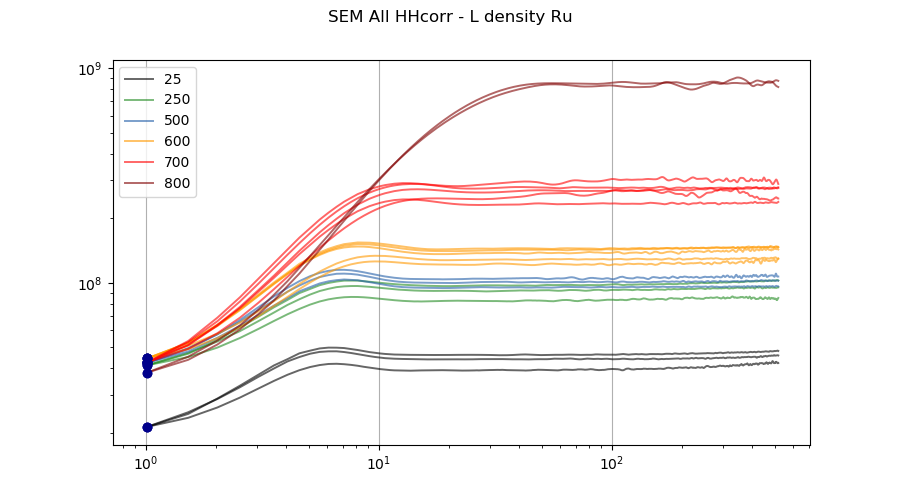

In [9]:
# *** If I want to see each single HHcorr function (interpolated but not averaged)
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250','500','600','700','800']
colors = ['black','forestgreen', '#225ea8', '#ff9900', '#ff0000', '#800000']

density = 'L'

for temp, color in zip(temperatures, colors):
    selection = df[df.temp==temp]
    selection = selection[selection.density==density]
    label = temp
    for idx, row in selection.iterrows():
        ax.loglog(
            x_new[density][ref_idx:],
            row.hhcorr_interp_offset[ref_idx:],
            c = color,
            alpha = 0.6,
            linewidth = 1.4,
            label = label
        )
        ax.scatter(x_new[density][ref_idx], row.hhcorr_interp_offset[ref_idx], c='darkblue', zorder=10)
        label = None
ax.legend()
titl = f"SEM All HHcorr - {density} density Ru"
fig.suptitle(titl)
ax.xaxis.grid() # vertical lines
figname = f"{titl}.png"
# fig.savefig(f'SEM_All HH-correlation functions in one plot - {density} density Ru.png', dpi=600)

# Plot Average HHcorr, without fit

<IPython.core.display.Javascript object>


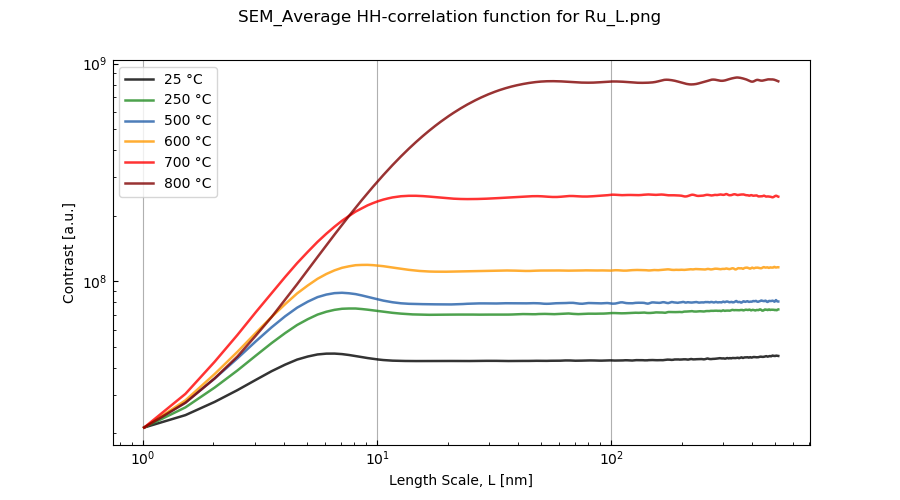

In [27]:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250','500','600','700','800']
colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

density = 'L'
for temp, color in zip(temperatures, colors):

    label = f"{temp} °C"
    ax.loglog(
        x_new[density][ref_idx:],
        adj_hhcorr[density][temp]['value'][ref_idx:],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )

    label = None
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Contrast [a.u.]')
ax.set(xlabel='Length Scale, L [nm]')

titl = f"SEM_Average HH-correlation function for Ru_{density}.png"
fig.suptitle(titl)

# figname = f"{titl}.png"
fig.savefig(f'{titl}', dpi=600)


ax.xaxis.grid() # vertical lines


# Fit the data

In [ ]:
interval = {}
for d in densities:
    interval [d] = {}
    for t in temperatures:
        interval[d][t]={}
        print(d,t)
        interval[d][t]['x0'] = int(input('x0 index:'))
        interval[d][t]['cutoff_idx'] = int(input('cutoff index:'))
print(interval)
interval

with open('Intervals_SEM.json', 'w') as f:
    json.dump(interval, f, indent=3)

In [20]:
with open('Intervals_SEM.json', 'r') as f:
    interval = json.loads(f.read()) 

# new dataframe
temperatures = ['25','250','500','600','700','800']
# temperatures = ['25','250']
densities = ['L','H','LH']

Model = lambda x, a, alpha: a*x**(2*alpha)  

df_results = pd.DataFrame(columns= 
                   ['density',
                    'temp', 
                    'saturation',
                    'alpha',
                    'corrlen'])  
fit ={}
corrlen ={}
y_err={}
for dens in densities:
    fit[dens] = {}
    corrlen[dens]={}
    y_err[dens]={}
    for t in temperatures:
        corrlen[dens][t]={}
        y_err[dens][t]={}
        fit[dens][t]={}
        fit[dens][t]['density'] = dens
        fit[dens][t]['temperature'] = t
        
        if len(AvHHcorr[dens][t])==0:
            continue
            
        fit[dens][t]['limit'] = np.mean(AvHHcorr[dens][t]['value'][30:500]) #this was [30:500] 
        
#         y_err[dens][t] = (np.sqrt(AvHHcorr[dens][t]['value']))
#         y_err[dens][t] = np.arange(x0,200)**3


        x0 = interval[dens][t]['x0']
        cutoff_idx = interval[dens][t]['cutoff_idx']
        fit[dens][t]['results'], _ = curve_fit(
                                        Model, 
                                        x_new[dens][x0:cutoff_idx], 
                                        AvHHcorr[dens][t]['value'][x0:cutoff_idx],
                                        sigma = None
#                                         sigma = y_err[dens][t][x0:cutoff_idx]
#                                         bounds = (x0,cutoff_idx)
                                        )
        a =  fit[dens][t]['results'][0]
        alpha  =  fit[dens][t]['results'][1]

        corrlen[dens][t] = (1/a*(fit[dens][t]['limit']))**(1/(2*alpha))

# *** Create new dataframe for the calculation of CorrLen and Alpha on this data:
        df_results = df_results.append( 
                {'density': fit[dens][t]['density'],
                 'temp': fit[dens][t]['temperature'],  
                 'saturation': fit[dens][t]['limit'], 
                 'alpha': alpha,
                 'corrlen': corrlen[dens][t]
                },
                ignore_index=True)

pickle.dump(df_results, open( "SEM_AvHHcorr_interpolated.p", "wb" ) )
df_results.to_excel("output_July2020.xlsx")  # doctest: +SKIP

<IPython.core.display.Javascript object>


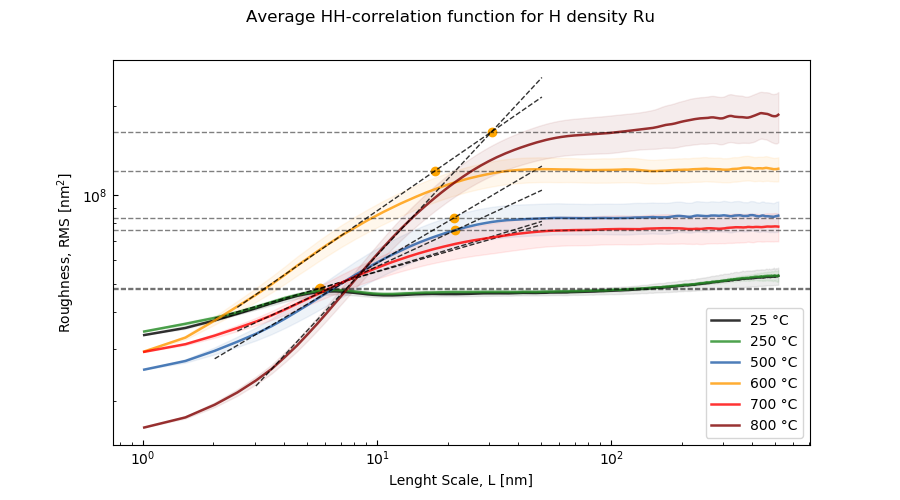

Text(0.5, 0.98, 'Average HH-correlation function for H density Ru')

In [21]:
# *** Plot everything in one graph:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25', '250','500', '600', '700', '800']
# temperatures = ['25', '250']

colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    
    if len(AvHHcorr[density][temp])==0:
        continue
    
    density = 'H'
    
    label = f"{temp} °C"
    ax.loglog(
        x_new[density][1:],
        AvHHcorr[density][temp]['value'][1:],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )
    ax.fill_between(
        x_new[density][1:],
        AvHHcorr[density][temp]['value_lower'][1:],
        AvHHcorr[density][temp]['value_upper'][1:],
        color = color,
        alpha = 0.075
    )
    
    ax.loglog(
        x_new[density][interval[dens][temp]['x0']:100], 
        Model(x_new[density][interval[dens][temp]['x0']:100],*fit[density][temp]['results']), 
        linewidth = 1, 
        linestyle='dashed', 
        alpha = 0.8, 
        c ='k')
    ax.scatter(corrlen[density][temp], fit[density][temp]['limit'], marker='o', color='orange')
    ax.axhline(fit[density][temp]['limit'], linestyle="dashed",linewidth = 1, color = 'black', zorder =5, alpha =0.5)
    

    label = None

ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Roughness, RMS [nm$^2$]')
ax.set(xlabel='Lenght Scale, L [nm]')
titl = f"Average HH-correlation function for {density} density Ru"
fig.suptitle(titl)

# figname = f"{titl}.png"
# fig.savefig(f'SEM_Average HH function - Ru_{density}_asDepOnly_2ndcorr.png', dpi=600)